# Introducción a agentes con LangGraph

`LangGraph` es un marco de orquestación de bajo nivel para construir agentes controlables

Mientras que `LangChain` proporciona integraciones y componentes para agilizar el desarrollo de aplicaciones LLM, la biblioteca `LangGraph` permite la orquestación de agentes, ofreciendo arquitecturas personalizables, memoria a largo plazo y `human in the loop` para manejar de manera confiable tareas complejas.

> En este post vamos a deshabilitar `LangSmith`, que es una herramienta de depuración de grafos. Lo vamos a deshabilitar para no añadir más complejidad al post y centrarnos únicamente en `LangGraph`

## ¿Cómo funciona `LangGraph`?

`LangGraph` se basa en tres componentes:

 * **Nodos**: Representan las unidades de procesamiento de la aplicación, como llamar a un LLM, o a una herramienta. Son funciones de Python que se ejecutan cuando se llama al nodo.
   * Tomar el estado como entrada
   * Realizan alguna operación
   * Devuelven el estado actualizado
 * **Edges**: Representan las transiciones entre los nodos. Definen la lógica de cómo se va a ejecutar el grafo, es decir, qué nodo se va a ejecutar después de otro. Pueden ser:
   * Directos: Van de un nodo a otro
   * Condicionales: Dependen de una condición
 * **State**: Representa el estado de la aplicación, es decir, contiene toda la información necesaria para la aplicación. Se mantiene durante la ejecución de la aplicación. Es definido por el usuario, así que hay que pensar muy bien qué se va a guardar en él.

![LangGraph concept](https://images.maximofn.com/langgraph_concept.webp)

Todos los grafos de `LangGraph` comienzan desde un nodo `START` y terminan en un nodo `END`.

## Instalación de LangGraph

In [ ]:
%pip install -U langgraph

## Instalación de módulo Anthropic

In [ ]:
pip install langchain_anthropic

## API KEY de Anthropic

Para poder la API de Anthropic, lo primero que necesitas es tener una cuenta en Antrhopic. Una vez la tengas, hay que ir a [keys](https://console.anthropic.com/settings/keys) y generar una nueva key.

Hay que ponerle un nombre. En mi caso, le voy a poner `langgraph`. Nos creará una key que tendremos que copiar

Para gestionar la key, vamos a crear un archivo en la misma ruta en la que estemos trabajando llamado `.env` y vamos a poner la key que hemos copiado en el archivo de la siguiente manera:

``` bash
ANTHROPIC_LANGGRAPH_API_KEY=="sk_...."
```

Ahora, para poder obtener el token, necesitamos tener instalado `dotenv`, que lo instalamos mediante

In [7]:
%pip install python-dotenv

In [1]:
import os
import dotenv

dotenv.load_dotenv()

ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

## Crear un chatbot básico

Vamos a crear un chatbot simple usando `LangGraph`. Este chatbot responderá directamente a los mensajes del usuario. Aunque es simple, nos servirá para ver los conceptos básicos de la construcción de grafos con `LangGraph`.

Como su nombre indica, `LangGraph` es una biblioteca para manejar grafos. Así que comenzamos creando un grafo [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.state.StateGraph).

Un `StateGraph` define la estructura de nuestro chatbot como una `máquina de estados`. Agregaremos `nodos` a nuestro grafo para representar los `llm`s, `tool`s y `funciones`, los `llm`s podrán hacer uso de esas `tool`s y `funciones`; y añadimos `edges` para especificar cómo el bot debe hacer la transición entre esos `nodos`.

Así que comenzamos creando un `StateGraph` que necesita una clase `State` para manejar el estado del grafo. Como ahora vamos a crear un chatbot sencillo, solo necesitamos manejar una lista de mensajes en el estado.

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

La función [add_messages](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages) une dos listas de mensajes.

Llegarán nuevas listas de mensajes, por lo que se unirán a la lista de mensajes ya existente. Cada lista de mensajes contiene un `ID`, por lo que se agregan con este `ID`. Esto asegura que los mensajes solo se añaden, no se reemplazan, a no ser que un nuevo mensaje tenga el mismo `ID` que uno ya existente, que entonces se remplaza.

`add_messages` es una [reducer function](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers), es una función que se encarga de actualizar el estado.

El grafo `graph_builder` que hemos creado, recibe un estado `State` y devuelve un nuevo estado `State`. Además, actualiza la lista de mensajes.

 > **Concepto**
 >
 > Al definir un grafo, el primer paso es definir su `State`. El `State` incluye el esquema del grafo y las `reducer functions` que manejan actualizaciones del estado.
 >
 > En nuestro ejemplo, `State` es de tipo `TypedDict` (diccionario tipado) con una llave: `messages`.
 >
 > `add_messages` es una `reducer function` que se utiliza para agregar nuevos mensajes a la lista en lugar de sobrescribirlos en la lista. Si una llave de un estado no tiene una `reducer function`, cada valor que llegue de esa clave sobrescribirán los valores anteriores.
 >
 > `add_messages` es una `reducer function` de langgraph, pero nosotros vamos a poder crear las nuestras

Ahora vamos a agregar al grafo el nodo `chatbot`. Los nodos representan unidades de trabajo. Por lo general, son funciones regulares de `Python`.

Añadimos un nodo con el método `add_node` que recibe el nombre del nodo y la función que se ejecutará.

De modo que vamos a crear un LLM con HuggingFace, después crearemos un chat model con `LangChain` que hará referencia al LLM creado. Una vez tenemos definido un chat model, definimos la función que se ejecutará en el nodo de nuestro grafo. Esa función hará una llamada al chat model creado y devolverá el resultado.

Por último vamos a añadir un nodo con la función del chatbot al grafo

In [3]:
from langchain_anthropic import ChatAnthropic
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", api_key=ANTHROPIC_TOKEN)

# Define the chatbot function
def chatbot_function(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot_node", chatbot_function)

Hemos usado [ChatHuggingFace](https://python.langchain.com/api_reference/huggingface/chat_models/langchain_huggingface.chat_models.huggingface.ChatHuggingFace.html#langchain_huggingface.chat_models.huggingface.ChatHuggingFace) que es un chat del tipo [BaseChatModel](https://python.langchain.com/api_reference/core/language_models/langchain_core.language_models.chat_models.BaseChatModel.html#langchain_core.language_models.chat_models.BaseChatModel) que es un tipo de chat base de `LangChain`. Una vez hemos creado el `BaseChatModel`, hemos creado la función `chatbot_function` que se ejecutará cuando se ejecute el nodo. Y por último, hemos creado el nodo `chatbot_node` y le hemos indicado que tiene que ejecutar la función `chatbot_function`.

 > **Aviso**
 >
 > La función de nodo `chatbot_function` toma el estado `State` como entrada y devuelve un diccionario que contiene una actualización de la lista `messages` para la key `mensajes`. Este es el patrón básico para todas las funciones del nodo `LangGraph`.

La `reducer function` de nuestro grafo `add_messages` agregará los mensajes de respuesta del `llm` a cualquier mensaje que ya esté en el estado.

A continuación, agregamos un nodo `entry`. Esto le dice a nuestro grafo dónde empezar su trabajo cada vez que lo ejecutamos.

In [4]:
from langgraph.graph import START

graph_builder.add_edge(START, "chatbot_node")

Del mismo modo, añadimos un nodo `finish`. Esto indica al grafo cada vez que se ejecuta este nodo, puede terminar el trabajo.

In [5]:
from langgraph.graph import END

graph_builder.add_edge("chatbot_node", END)

Hemos importado `START` y `END` que podemos encontrarlos en [constants](https://langchain-ai.github.io/langgraph/reference/constants/) y son el primer y el último nodo de nuestro grafo.

Normalmente son nodos virtuales

Finalmente, tenemos que compilar nuestro grafo. Para hacerlo, usamos el método constructor de grafos `compile()`. Esto crea un `CompiledGraph` que podemos usar para ejecutar nuestra aplicación.

In [6]:
graph = graph_builder.compile()

Podemos visualizar el grafo usando el método `get_graph` y uno de los métodos de "dibujo", como `draw_ascii` o `draw_mermaid_png`. El dibujo de cada uno de los métodos requiere dependencias adicionales.

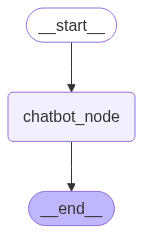

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

¡Ahora podemos probar el chatbot!

 > **Consejo**
 >
 > En el siguiente bloque de código, puedes salir del bucle de chat en cualquier momento escribiendo `quit`, `exit` o `q`.

In [8]:
# Colors for the terminal
COLOR_GREEN = "\033[32m"
COLOR_YELLOW = "\033[33m"
COLOR_RESET = "\033[0m"


def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print(f"{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
            print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}{value['messages'][-1].content}")


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print(f"{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
            print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}Goodbye!")
            break

        events =stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: What was the result of Real Madrid's at last match in the Champions League?
User: What was the result of Real Madrid's at last match in the Champions League?
Assistant: I am not able to provide real-time sports results or know specific match outcomes without being updated. To find out Real Madrid's most recent Champions League match result, I recommend checking official sports websites, UEFA's website, or Real Madrid's official channels.
User: q
User: q
Assistant: Goodbye!


**!Felicidades!** Has construido tu primer chatbot usando `LangGraph`. Este bot puede participar en una conversación básica tomando la entrada del usuario y generando respuestas utilizando el `LLM` que hemos definido.

Antes hemos ido escribiendo el código poco a poco y puede que no haya quedado muy claro. Se ha hecho así para explicar cada parte del código, pero ahora vamos a volver a escribirlo, pero ordenado de otra manera, que queda más claro a la vista. Es decir, ahora que no hay que explicar cada parte del código, lo agrupamos de otra manera para que sea más claro

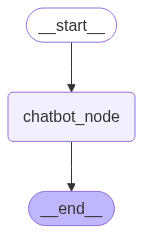

In [9]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_anthropic import ChatAnthropic

from IPython.display import Image, display

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Create the LLM model
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", api_key=ANTHROPIC_TOKEN)

# Function
def chatbot_function(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("chatbot_node", chatbot_function)

# Add edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile()

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

## Mejorar el chatbot con herramientas

Para manejar algunas consultas, nuestro chatbot no puede responder `desde su conocimiento`, así que vamos a integrar una herramienta de búsqueda web. Nuestro bot puede utilizar esta herramienta para encontrar información relevante y proporcionar mejores respuestas.

### Requisitos

Antes de comenzar, tenemos que instalar el buscador [Tavily](https://python.langchain.com/docs/integrations/tools/tavily_search/) que es un buscador web que nos permite buscar información en la web.

In [ ]:
%pip install -U tavily-python langchain_community

Después, tenemos que crear una [API KEY](https://app.tavily.com/home), la escribimos en nuestro archivo `.env` y la cargamos en una variable.

In [1]:
import dotenv
import os

dotenv.load_dotenv()

ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

### Chatbot con tools

Primero creamos el estado y el LLM

In [2]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_anthropic import ChatAnthropic

import json
import os
from IPython.display import Image, display

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

class State(TypedDict):
    messages: Annotated[list, add_messages]

# Create the LLM
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)

# Start to build the graph
graph_builder = StateGraph(State)

Ahora, definimos la herramienta de búsqueda web mediante [TavilySearchResults](https://python.langchain.com/api_reference/community/tools/langchain_community.tools.tavily_search.tool.TavilySearchResults.html)

In [3]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)

<ipython-input-3-3136919182>:7: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)


Probamos la herramienta, vamos a hacer una búsqueda en Internet

In [4]:
tool.invoke("What was the result of Real Madrid's at last match in the Champions League?")

[{'title': "Real Madrid's greatest UEFA Champions League comebacks - ESPN",
  'url': 'https://www.espn.com/soccer/story/_/id/44681247/real-madrids-greatest-uefa-champions-league-comebacks',
  'content': 'Madrid would go on to defeat Borussia Dortmund 2-0 in the final, with goals from Dani Carvajal and Vinícius sealing another unforgettable',
  'score': 0.7253574},
 {'title': "Real Madrid's Champions League ouster by Arsenal reinforces an ...",
  'url': 'https://sports.yahoo.com/soccer/live/real-madrids-champions-league-ouster-by-arsenal-reinforces-an-age-old-soccer-truth-190017620.html',
  'content': 'But a year later, the sport clapped back.\n\nOn Wednesday, Real Madrid slumped out of the Champions League, beaten comprehensively by Arsenal over two legs, 5-1.\n\nKylian Mbappé and Vinicius Jr. crept off the field after a sour second leg, or simply stood there, dumbfounded, because on paper, their team was more super than ever before; but in practice, soccer is the ultimate team game. [

Los resultados son resúmenes de páginas que nuestro chatbot puede usar para responder preguntas.

Creamos una lista de herramientas, porque nuestro grafo necesita definir las herramientas mediante una lista.

In [5]:
tools_list = [tool]

Ahora que tenemos la lista de `tool`s creamos un `llm_with_tools`

In [6]:
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools_list)

Definimos la función que irá en el nodo chat bot

In [7]:
# Define the chatbot function
def chatbot_function(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

Necesitamos crear una función para ejecutar las `tools_list` si se llaman. Agregamos las `tools_list` a un nuevo nodo.

Más tarde haremos esto con el método [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) de `LangGraph`, pero primero lo construiremos nosotros mismos para entender cómo funciona.

Vamos a usar los métodos de LangGraph `ToolNode` y `tools_condition`, que sirven para añadir un nodo de tipo Tool al grafo y determinan si se tiene que usar la tool o no

Se basa en el soporte de `tool_calling` de los `LLM`s , que está disponible en `Anthropic`, `HuggingFace`, `Google Gemini`, `OpenAI` y varios otros proveedores de `LLM`.

In [8]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

Ahora, igual que hicimos cuando construimos un chatbot básico, vamos a crear el grafo y añadirle nodos

In [9]:
# Create graph
graph_builder = StateGraph(State)

# Add the chatbot node
graph_builder.add_node("chatbot_node", chatbot_function)
graph_builder.add_node("tools", tool_node)

ACuando el LLM reciba un mensaje, como conoce las `tool`s que tiene a disposición, decidirá si contestar o usar una `tool`. Así que vamos a añadir esto al grafo

In [10]:
graph_builder.add_conditional_edges(
    "chatbot_node",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot_node")

Añadimos los `edge`s.

Tenemos que añadir un `edge` especial mediante `add_conditional_edges`, que creará un nodo condicional. Une el nodo `chatbot_node` con la función de rutado que hemos creado antes `route_tools_function`. Con este nodo, si obtenemos a la salida de `route_tools_function` el string `tools_node` rutará el grafo al nodo `tools_node`, pero si recibimos `END` rutará el grafo al nodo `END` y terminará la ejecución del grafo

Más tarde, reemplazaremos esto con el método preconstruido `tools_condition`, pero ahora lo implementamos nosotros mismos para ver cómo funciona.

In [11]:
# Add edges
graph_builder.add_edge(START, "chatbot_node")

Compilamos el nodo y lo representamos

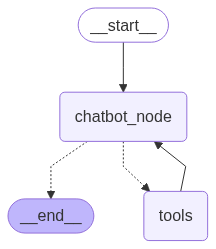

In [12]:
graph = graph_builder.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Ahora podemos hacer preguntas al bot fuera de sus datos de entrenamiento

In [13]:
# Colors for the terminal
COLOR_GREEN = "\033[32m"
COLOR_YELLOW = "\033[33m"
COLOR_RESET = "\033[0m"


def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print(f"{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
            print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}{value['messages'][-1].content}")

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print(f"{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
            print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: What was the result of Real Madrid's at last match in the Champions League?
User: What was the result of Real Madrid's at last match in the Champions League?
Assistant: [{'text': "I'll help you find information about Real Madrid's latest Champions League match result. Let me search for that information for you.", 'type': 'text'}, {'id': 'toolu_01Bo7resCV5YzYbUw56WZ7AM', 'input': {'query': 'Real Madrid latest Champions League match result 2024'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
User: What was the result of Real Madrid's at last match in the Champions League?
Assistant: [{"title": "Real Madrid full schedule 2024-25, results, top scorers - NBC Sports", "url": "https://www.nbcsports.com/soccer/news/real-madrid-full-schedule-2024-25-when-is-kylian-mbappe-and-jude-bellinghams-next-game", "content": "August 18, 2024: Mallorca 1-1 Real Madrid  \nAugust 25, 2024: Real Madrid 3-0 Valladolid  \nAugust 29, 2024: Las Palmas 1-1 Real Madrid  \nSeptember 1, 2024: Real

Como ves, primero le he preguntado por el último partido del Real Madrid

Sin embargo, a continuación le he preguntado qué jugadores jugaron y no sabía de qué le hablaba, eso es porque no se mantiene el contexto de la conversación. Así que lo siguiente que vamos a hacer es agregar una memoria al agente para que pueda mantener el contexto de la conversación.

Vamos a escribir todo junto para que sea más legible

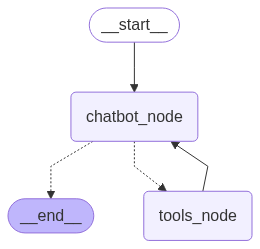

In [14]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_anthropic import ChatAnthropic

from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

from langchain_core.messages import ToolMessage

from IPython.display import Image, display
import json

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Tools
wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)
tools_list = [tool]
# Create the LLM model
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", api_key=ANTHROPIC_TOKEN)
# Create the LLM with tools
llm_with_tools = llm.bind_tools(tools_list)

# BasicToolNode class
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        """
        Initialize the tools

        Args:
            tools (list): The tools to use

        Returns:
            None
        """
        # Initialize the tools
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        """
        Call the node

        Args:
            inputs (dict): The inputs to the node

        Returns:
            dict: The outputs of the node
        """
        # Get the last message
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # Execute the tools
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

basic_tool_node = BasicToolNode(tools=tools_list)

# Functions
def chatbot_function(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Route function
def route_tools_function(state: State):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    # Get last message
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # Router in function of last message
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools_node"
    return END

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("chatbot_node", chatbot_function)
graph_builder.add_node("tools_node", basic_tool_node)

# Add edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_conditional_edges(
    "chatbot_node",
    route_tools_function,
    {
        "tools_node": "tools_node",
        END: END
    },
)
graph_builder.add_edge("tools_node", "chatbot_node")

# Compile the graph
graph = graph_builder.compile()

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Ejecutamos el grafo

In [ ]:
# Colors for the terminal
COLOR_GREEN = "\033[32m"
COLOR_YELLOW = "\033[33m"
COLOR_RESET = "\033[0m"


def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print(f"{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
            print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}{value['messages'][-1].content}")

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print(f"{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
            print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Volvemos a ver que el problema es que no recuerda el contexto de la conversación.

## Agregar memoria al chatbot - memoria a corto plazo, memoria dentro del hilo

Nuestro chatbot ahora puede usar herramientas para responder preguntas de los usuarios, pero no recuerda el contexto de las interacciones anteriores. Esto limita su capacidad de tener conversaciones coherentes y de múltiples turnos.

`LangGraph` resuelve este problema a través de puntos de control persistentes o `checkpoints`. Si le proporcionamos un `checkpointer` al compilar el grafo y un `thread_id` al llamar al grafo, `LangGraph` guarda automáticamente el estado después de cada iteración en la conversación.

Cuando invoquemos el grafo nuevamente usando el mismo `thread_id`, el grafo cargará su estado guardado, permitiendo que el chatbot continúe donde lo dejó.

Veremos más tarde que ese `checkpointing` es mucho más potente que la simple memoria de chat: le permite guardar y reanudar estados complejos en cualquier momento para la recuperación de errores, flujos de trabajo con `human in the loop`, interacciones en el tiempo y más. Pero antes de ver todo eso, vamos a agregar puntos de control para permitir conversaciones de varias iteraciones.

In [1]:
import os
import dotenv

dotenv.load_dotenv()

ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

Para empezar, creamos un `checkpointer` [MemorySaver](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver).

In [2]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

 > **Aviso**
 >
 > Estamos usando un `checkpointer` en memoria, es decir, se guarda en la RAM y cuando se termine de ejecutar el grafo se elimina. Esto nos vale para nuestro caso, ya que es un ejemplo para aprender a usar `LangGraph`. En una aplicación de producción, es probable que se necesite cambiar esto para usarlo con `SqliteSaver` o `PostgresSaver` y conéctarnos a nuestra propia base de datos.

A continuación, definimos el grafo.

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

Definimos la `tool`

In [4]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)
tools_list = [tool]

<ipython-input-4-3315549533>:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)


A continuación, el `LLM` con las `bind_tools` y lo añadimos al grafo

In [5]:
from langchain_anthropic import ChatAnthropic
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", api_key=ANTHROPIC_TOKEN)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools_list)

# Define the chatbot function
def chatbot_function(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Add the chatbot node
graph_builder.add_node("chatbot_node", chatbot_function)

Antes construimos nuestro propio `BasicToolNode` para aprender cómo funciona, ahora lo reemplazaremos con el método de LangGraph `ToolNode` y `tools_condition`, ya que estos hacen algunas cosas buenas como la ejecución paralela de API. Aparte de eso, el resto es igual que antes.

In [6]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

Añadimos el nodo de `tools_condition` al grafo

In [7]:
graph_builder.add_conditional_edges(
    "chatbot_node",
    tools_condition,
)

Añadimos el nodo de `tools` al grafo

In [8]:
graph_builder.add_edge("tools", "chatbot_node")

Añadimos el nodo de `START` al grafo

In [9]:
graph_builder.add_edge(START, "chatbot_node")

Compilamos el grafo añadiendo el `checkpointer`

In [10]:
graph = graph_builder.compile(checkpointer=memory)

Lo representamos gráficamente

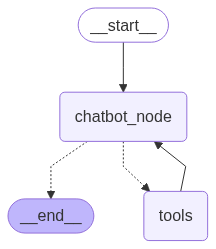

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Creamos una configuración con un `thread_id` de un usuario

In [12]:
USER1_THREAD_ID = "1"
config_USER1 = {"configurable": {"thread_id": USER1_THREAD_ID}}

In [13]:
user_input = "Hi there! My name is Maximo."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER1,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Maximo.
================================== Ai Message ==================================

Hello Maximo! Nice to meet you. I'm an AI assistant with access to search capabilities that can help you find information and answer questions. Is there anything specific you'd like to know about or discuss?


In [14]:
user_input = "Do you remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER1,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Do you remember my name?
================================== Ai Message ==================================

Yes, you told me your name is Maximo!


Como se puede ver, no hemos pasado una lista con los mensajes, todo está siendo gestionado por el `checkpointer`.

Si ahora probamos con otro usuario, es decir, con otro `thread_id`, veremos que el grafo no recuerda la conversación anterior.

In [15]:
USER2_THREAD_ID = "2"
config_USER2 = {"configurable": {"thread_id": USER2_THREAD_ID}}

user_input = "Do you remember my name?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER2,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Do you remember my name?
================================== Ai Message ==================================

I don't have access to any previous conversation history or personal information about users. I start fresh with each conversation and don't maintain any memory of past interactions. If you'd like me to know your name, you'll need to tell me what it is.


Ahora que nuestro chatbot tiene herramientas de búsqueda y memoria, vamos a repetir el ejemplo anterior, donde le pregunto por el resultado del último partido del Real Madrid en la Liga y luego por qué jugadores jugaron.

In [18]:
USER3_THREAD_ID = "3"
config_USER3 = {"configurable": {"thread_id": USER3_THREAD_ID}}

user_input = "How did Real Madrid fare against Leganes in La Liga?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER3,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

How did Real Madrid fare against Leganes in La Liga?
================================== Ai Message ==================================

[{'text': 'Let me search for information about the recent Real Madrid vs Leganes match in La Liga.', 'type': 'text'}, {'id': 'toolu_01T4iNC1PuDrAeKk9ZVmGQLp', 'input': {'query': 'Real Madrid vs Leganes La Liga 2024 result'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01T4iNC1PuDrAeKk9ZVmGQLp)
 Call ID: toolu_01T4iNC1PuDrAeKk9ZVmGQLp
  Args:
    query: Real Madrid vs Leganes La Liga 2024 result
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Real Madrid 3-0 Leganés (Nov 24, 2024) Final Score - ESPN", "url": "https://www.espn.com/soccer/match/_/gameId/704796/real-madrid-leganes", "content": "| [Leganés](/soccer/team/_/id/17534/leganes

Ahora le preguntamos por los jugadores que jugaron en el partido.

In [19]:
user_input = "Which players played the match?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER3,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Which players played the match?
================================== Ai Message ==================================

[{'text': 'Let me search for the lineup and player information from this match.', 'type': 'text'}, {'id': 'toolu_019NcLcZAFmaFsESu22YsP5t', 'input': {'query': 'Real Madrid vs Leganes November 24 2024 La Liga lineups starting XI players'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_019NcLcZAFmaFsESu22YsP5t)
 Call ID: toolu_019NcLcZAFmaFsESu22YsP5t
  Args:
    query: Real Madrid vs Leganes November 24 2024 La Liga lineups starting XI players
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "CONFIRMED lineups: Leganes vs Real Madrid, 2024 LaLiga", "url": "https://www.managingmadrid.com/2024/11/24/24304577/leganes-vs-real-madrid-2024-la-liga-live-online-strea

Tras mucho buscar, al final lo encuentra. Por lo que ya tenemos un chatbot con `tools` y memoria.

Por ahora, hemos creado unos `checkpoints` en tres hilos diferentes. Pero, ¿qué entra en cada `checkpoint`? Para inspeccionar el estado de un grafo para una configuración dada podemos usar el método `get_state(config)`.

In [20]:
snapshot = graph.get_state(config_USER3)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='How did Real Madrid fare against Leganes in La Liga?', additional_kwargs={}, response_metadata={}, id='c0f69c6c-0c67-4fea-9030-6d0e2e00a55a'), AIMessage(content=[{'text': 'Let me search for information about the recent Real Madrid vs Leganes match in La Liga.', 'type': 'text'}, {'id': 'toolu_01T4iNC1PuDrAeKk9ZVmGQLp', 'input': {'query': 'Real Madrid vs Leganes La Liga 2024 result'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01UUpvtCcdmaSeLDhZ7Hkxcp', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 429, 'output_tokens': 90, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-3-5-sonnet-20241022'}, id='run--076c0b90-fdee-4a51-8b29-6140676af3b2-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'que

Si queremos ver el siguiente nodo a procesar, podemos usar el atributo `next`

In [21]:
snapshot.next

()

Dado que el grafo ha finalizado, `next` está vacío. Si obtienes un estado desde dentro de una invocación del grafo, `next` indica qué nodo se ejecutará a continuación.

La instantánea anterior (`snapshot`) contiene los valores de estado actuales, la configuración correspondiente y el siguiente nodo (`next`) a procesar. En nuestro caso, el gráfico ha alcanzado el estado `END`, por eso `next` está vacío.

Vamos a volver a escribir todo el código para que sea más legible.

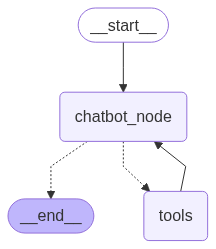

In [22]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login

from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.checkpoint.memory import MemorySaver

from IPython.display import Image, display
import json

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Tools
wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)
tools_list = [tool]

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)
# Create the LLM with tools
llm_with_tools = llm.bind_tools(tools_list)

# Tool node
tool_node = ToolNode(tools=tools_list)

# Functions
def chatbot_function(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("chatbot_node", chatbot_function)
graph_builder.add_node("tools", tool_node)

# Add edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_conditional_edges( "chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")

# Compile the graph
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

In [ ]:
USER1_THREAD_ID = "1"
config_USER1 = {"configurable": {"thread_id": USER1_THREAD_ID}}

user_input = "Hi there! My name is Maximo."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER1,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Maximo.
================================== Ai Message ==================================

Hello Maximo! It's nice to meet you. How can I assist you today? Feel free to ask me any questions or let me know if you need help with anything specific.


In [ ]:
user_input = "Do you remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER1,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Do you remember my name?
================================== Ai Message ==================================

Yes, I remember your name! You mentioned it's Maximo. It's nice to chat with you, Maximo. How can I assist you today?


**¡Felicidades!** Nuestro chatbot ahora puede mantener el estado de conversación en todas las sesiones gracias al sistema de puntos de control (`checkpoints`) de `LangGraph`. Esto abre posibilidades para interacciones más naturales y contextuales. El control de `LangGraph` incluso maneja estados de grafos complejos.

## Memoria a largo plazo, memoria entre hilos

La memoria es una función cognitiva que permite a las personas almacenar, recuperar y utilizar información para comprender, a partir de su pasado, su presente y su futuro.

Existen varios tipos de [memoria](https://langchain-ai.github.io/langgraph/concepts/memory) a largo plazo que pueden utilizarse en aplicaciones de IA.

### Introducción a LangGraph Memory Store

LangGraph proporciona el [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore), que es una forma de guardar y recuperar memoria a largo plazo entre diferentes hilos. De esta manera, en una conversación, un usuario puede indicar que le gusta algo, y en otra conversación, el chatbot puede recuperar esa información para generar una respuesta más personalizada.

Se trata de una clase para almacenes persistentes de clave-valor (`key`-`value`).

Cuando se almacenan objetos en la memoria se necesitan tres cosas:
 * Un `namespace` para el objeto, se hace mediante una `tupla`
 * Una `key` única
 * El `valor` del objeto

Vamos a ver un ejemplo

In [1]:
import uuid
from langgraph.store.memory import InMemoryStore

in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())

# The value needs to be a dictionary
value = {"food_preference" : "I like pizza"}

# Save the memory
in_memory_store.put(namespace_for_memory, key, value)

El objeto `in_memory_store` que hemos creado tiene varios [métodos](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) y uno de ellos es `search`, que nos permite buscar por `namespace`

In [2]:
# Search
memories = in_memory_store.search(namespace_for_memory)
type(memories), len(memories)

(list, 1)

Es una lista de un único valor, lo cual es lógico, porque solo hemos almacenado un valor, así que vamos a verlo

In [3]:
value = memories[0]
value.dict()

{'namespace': ['1', 'memories'],
 'key': '73784c74-2a89-4f40-b975-ec3620ca2df5',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-06-13T15:43:11.549078+00:00',
 'updated_at': '2025-06-13T15:43:11.549087+00:00',
 'score': None}

Podemos ver su `key` y su `value`

In [4]:
# The key, value
memories[0].key, memories[0].value

('73784c74-2a89-4f40-b975-ec3620ca2df5', {'food_preference': 'I like pizza'})

También podemos usar el método `get` para obtener un objeto de la memoria a partir de su `namespace` y su `key`

In [5]:
# Get the memory by namespace and key
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

{'namespace': ['1', 'memories'],
 'key': '73784c74-2a89-4f40-b975-ec3620ca2df5',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-06-13T15:43:11.549078+00:00',
 'updated_at': '2025-06-13T15:43:11.549087+00:00'}

Al igual que para la memoria a corto plazo hemos usado los checkpoints, para la memoria a largo plazo vamos a usar `LangGraph Store`

### Chatbot con memoria a largo plazo

Creamos un chatbot básico, con memoria a largo plazo y memoria a corto plazo.

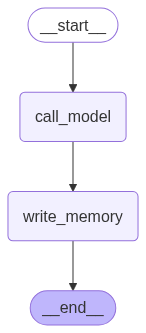

In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver # Short-term memory
from langgraph.store.base import BaseStore          # Long-term memory
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.memory import InMemoryStore
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", api_key=ANTHROPIC_TOKEN)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant that can answer questions and help with tasks.
You have access to a long-term memory that you can use to answer questions and help with tasks.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """You are a helpful assistant that gets information from the user to personalize your responses.

# INFORMATION FROM THE USER:
{memory}

# INSTRUCTIONS:
1. Carefully review the chat history
2. Identify new information from the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Combine any new information with the existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""

# Nodes
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    # Extract the actual memory content if it exists and add a prefix
    if existing_memory:
        # Value is a dictionary with a memory key
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."
    if isinstance(existing_memory_content, str):
        print(f"\t[Call model debug] Existing memory: {existing_memory_content}")
    else:
        print(f"\t[Call model debug] Existing memory: {existing_memory_content.content}")

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)

    # Respond using memory as well as the chat history
    response = llm.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Extract the memory
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."
    if isinstance(existing_memory_content, str):
        print(f"\t[Write memory debug] Existing memory: {existing_memory_content}")
    else:
        print(f"\t[Write memory debug] Existing memory: {existing_memory_content.content}")

    # Format the memory in the system prompt
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    new_memory = llm.invoke([SystemMessage(content=system_msg)]+state['messages'])
    if isinstance(new_memory, str):
        print(f"\n\t[Write memory debug] New memory: {new_memory}")
    else:
        print(f"\n\t[Write memory debug] New memory: {new_memory.content}")

    # Overwrite the existing memory in the store
    key = "user_memory"

    # Write value as a dictionary with a memory key
    store.put(namespace, key, {"memory": new_memory.content})

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("call_model", call_model)
graph_builder.add_node("write_memory", write_memory)

# Connect nodes
graph_builder.add_edge(START, "call_model")
graph_builder.add_edge("call_model", "write_memory")
graph_builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
long_term_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
short_term_memory = MemorySaver()

# Compile the graph
graph = graph_builder.compile(checkpointer=short_term_memory, store=long_term_memory)

display(Image(graph.get_graph().draw_mermaid_png()))

Vamos a probarlo

In [8]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="Hi, my name is Maximo")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Maximo
	[Call model debug] Existing memory: No existing memory found.
================================== Ai Message ==================================

Hello Maximo! Nice to meet you. I'll remember your name. How can I help you today?
	[Write memory debug] Existing memory: No existing memory found.

	[Write memory debug] New memory: 

Here's what I know about you so far:

• Name: Maximo


In [9]:
# User input
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
	[Call model debug] Existing memory: 

Here's what I know about you so far:

• Name: Maximo
================================== Ai Message ==================================

That's great that you enjoy cycling in San Francisco! I'll remember that about you. San Francisco is a beautiful but challenging city for biking, with its steep hills and iconic streets. Do you have any favorite routes or areas you particularly enjoy riding in? Some popular spots include the Embarcadero waterfront, Golden Gate Park, and crossing the Golden Gate Bridge into Marin County. I'd be curious to hear about your biking experiences in the city!
	[Write memory debug] Existing memory: 

Here's what I know about you so far:

• Name: Maximo

	[Write memory debug] New memory: 

Here's what I now know about you:

• Name: Maximo
• Location: San Francisco
• Interests/Hobbies: Cycling/biking


Si recuperamos la memoria a largo plazo

In [10]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = long_term_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'memory': "\n\nHere's what I now know about you:\n\n• Name: Maximo\n• Location: San Francisco\n• Interests/Hobbies: Cycling/biking"},
 'created_at': '2025-06-13T15:44:43.915561+00:00',
 'updated_at': '2025-06-13T15:44:43.915568+00:00'}

Obtenemos su valor

In [11]:
print(existing_memory.value.get('memory'))



Here's what I now know about you:

• Name: Maximo
• Location: San Francisco
• Interests/Hobbies: Cycling/biking


Ahora podemos empezar un nuevo hilo de conversación, pero con la misma memoria a largo plazo. Veremos que el chatbot recuerda la información del usuario.

In [12]:
# We supply a user ID for across-thread memory as well as a new thread ID
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="Hi! Where would you recommend that I go biking?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Where would you recommend that I go biking?
	[Call model debug] Existing memory: 

Here's what I now know about you:

• Name: Maximo
• Location: San Francisco
• Interests/Hobbies: Cycling/biking
================================== Ai Message ==================================

Hi Maximo! Since you're in San Francisco, you have access to some fantastic biking opportunities! Here are some top recommendations:

1. Golden Gate Bridge to Sausalito - A classic SF bike ride with stunning views. You can take the ferry back!

2. Golden Gate Park - Miles of bike-friendly paths through the park, including car-free JFK Drive on weekends.

3. The Presidio - Beautiful trails with forest and coastal views, plus connections to the Golden Gate Bridge.

4. Angel Island - Take a ferry with your bike and ride around the island for amazing bay views.

5. Mount Tamalpais - If you're into mountain biking or more challenging 

He abierto un nuevo hilo de conversación, le he preguntado dónde podría ir a montar en bici, ha recordado que le había dicho que me gusta ir a montar en bici por San Francisco y me ha respondido con lugares de San Francisco a los que podría ir

### Chatbot con perfil de usuario

Podemos crear tipados para que el LLM genere una salida con una estructura definida por nosotros.

Vamos a crear un tipado para el perfil de usuario.

In [13]:
from typing import TypedDict, List

class UserProfile(TypedDict):
    """User profile schema with typed fields"""
    user_name: str  # The user's preferred name
    interests: List[str]  # A list of the user's interests

Ahora volvemos a crear el grafo, pero ahora con el tipado `UserProfile`

Vamos a usar `with_structured_output` para que el LLM genere una salida con una estructura definida por nosotros, esa estructura la vamos a definir con la clase `Subjects` que es una clase de tipo `BaseModel` de `Pydantic`.

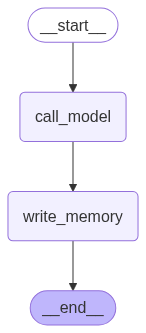

In [15]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver # Short-term memory
from langgraph.store.base import BaseStore          # Long-term memory
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.memory import InMemoryStore
from IPython.display import Image, display
from pydantic import BaseModel, Field
import os
import dotenv

dotenv.load_dotenv()
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", api_key=ANTHROPIC_TOKEN)
llm_with_structured_output = llm.with_structured_output(UserProfile)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """Create or update a user profile memory based on the user's chat history.
This will be saved for long-term memory. If there is an existing memory, simply update it.
Here is the existing memory (it may be empty): {memory}"""

# Nodes
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None
    # if isinstance(existing_memory_content, str):
    print(f"\t[Call model debug] Existing memory: {formatted_memory}")
    # else:
    #     print(f"\t[Call model debug] Existing memory: {existing_memory_content.content}")

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = llm.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None
    print(f"\t[Write memory debug] Existing memory: {formatted_memory}")

    # Format the existing memory in the instruction
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)

    # Invoke the model to produce structured output that matches the schema
    new_memory = llm_with_structured_output.invoke([SystemMessage(content=system_msg)]+state['messages'])
    print(f"\t[Write memory debug] New memory: {new_memory}")

    # Overwrite the existing use profile memory
    key = "user_memory"
    store.put(namespace, key, new_memory)

# Create graph builder
graph_builder = StateGraph(MessagesState)

# Add nodes
graph_builder.add_node("call_model", call_model)
graph_builder.add_node("write_memory", write_memory)

# Connect nodes
graph_builder.add_edge(START, "call_model")
graph_builder.add_edge("call_model", "write_memory")
graph_builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
long_term_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
short_term_memory = MemorySaver()

# Compile the graph
graph = graph_builder.compile(checkpointer=short_term_memory, store=long_term_memory)

display(Image(graph.get_graph().draw_mermaid_png()))

Ejecutamos el grafo

In [16]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="Hi, my name is Maximo and I like to bike around Madrid and eat salads.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Maximo and I like to bike around Madrid and eat salads.
	[Call model debug] Existing memory: None
================================== Ai Message ==================================

Hello Maximo! It's nice to meet you. I don't have any previous memory of our interactions, but I'll remember that you enjoy biking around Madrid and eating salads. Those are great healthy habits! Madrid is a wonderful city for cycling, with its bike lanes and parks like Retiro and Casa de Campo. Do you have any favorite cycling routes or special salad spots in Madrid that you particularly enjoy?
	[Write memory debug] Existing memory: None
	[Write memory debug] New memory: {'user_name': 'Maximo', 'interests': ['cycling', 'biking', 'healthy eating', 'salads', 'Madrid']}


Como vemos, el LLM ha generado una salida con la estructura definida por nosotros.

Vamos a ver cómo se ha guardado la memoria a largo plazo.

In [17]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = long_term_memory.get(namespace, "user_memory")
existing_memory.value

{'user_name': 'Maximo',
 'interests': ['cycling', 'biking', 'healthy eating', 'salads', 'Madrid']}

## Human in the loop

Aunque un agente puede realizar tareas, para según qué tareas, es necesario que haya una supervisión humana. A esto se le llama `human in the loop`. Así que vamos a ver cómo se puede hacer esto con `LangGraph`.

La capa de [persistencia](https://langchain-ai.github.io/langgraph/concepts/persistence/) de `LangGraph` admite flujos de trabajo con humanos en el bucle, lo que permite que la ejecución se detenga y reanude en función de los comentarios de los usuarios. La interfaz principal de esta funcionalidad es la función [interrupt](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/#interrupt). Llamando a `interrupt` dentro de un nodo se detendrá la ejecución. La ejecución se puede reanudar, junto con la nueva aportación del humano, pasada en una primitiva [Command](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/#the-command-primitive). `interrupt` es similar al comando de Python `input()`, pero con algunas consideraciones extra.

Vamos a añadir al chatbot que tiene memoria a corto plazo y acceso a tools, pero haremos un cambio, que es agregar una simple herramienta `human_assistance`. Esta herramienta utiliza `interrupt` para recibir información de un humano.

Primero cargamos los valores de las API KEYs

In [1]:
import os
import dotenv

dotenv.load_dotenv()

ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

Creamos el grafo

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

Definimos la `tool` de búsqueda

In [3]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
search_tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)

<ipython-input-3-2955814646>:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)


Ahora creamos la `tool` de ayuda humana

In [4]:
from langgraph.types import Command, interrupt
from langchain_core.tools import tool

@tool
def human_assistance(query: str) -> str:
    """
    Request assistance from a human expert. Use this tool ONLY ONCE per conversation.
    After receiving the expert's response, you should provide an elaborated response to the user based on the information received
    based on the information received, without calling this tool again.

    Args:
        query: The query to ask the human expert.

    Returns:
        The response from the human expert.
    """
    human_response = interrupt({"query": query})
    return human_response["data"]

`LangGraph` obtiene información de las herramientas mediante la documentación de la herramienta, es decir, el `docstring` de la función. Por lo que es muy importante generar un buen `docstring` para la herramienta.

Creamos una lista de `tools`

In [5]:
tools_list = [search_tool, human_assistance]

A continuación, el `LLM` con las `bind_tools` y lo añadimos al grafo

In [6]:
from langchain_anthropic import ChatAnthropic
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", api_key=ANTHROPIC_TOKEN)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools_list)

# Define the chatbot function
def chatbot_function(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

# Add the chatbot node
graph_builder.add_node("chatbot_node", chatbot_function)

Si te fijas, hemos cambiado la forma de definir la función `chatbot_function`, ya que ahora tiene que manejar la interrupción.

Añadimos la `tool_node` al grafo

In [7]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools=tools_list)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")

Añadimos el nodo de `START` al grafo

In [8]:
graph_builder.add_edge(START, "chatbot_node")

Creamos un `checkpointer` [MemorySaver](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver).

In [9]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

Compilamos el grafo con el `checkpointer`

In [10]:
graph = graph_builder.compile(checkpointer=memory)

Lo representamos gráficamente

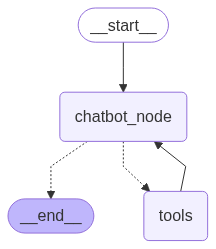

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Ahora solicitemos al chatbot con una pregunta que involucrará a la nueva herramienta `human_assistance`:

In [12]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================

[{'text': "I'll help you get expert guidance on building an AI agent. I'll use the human assistance tool to get specialized advice on this topic.", 'type': 'text'}, {'id': 'toolu_01HVn3hPNeZ4BYPavxbtNoK1', 'input': {'query': 'Could you provide guidance and best practices for building an AI agent? Please include key considerations for design, implementation, and potential challenges to be aware of.'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_01HVn3hPNeZ4BYPavxbtNoK1)
 Call ID: toolu_01HVn3hPNeZ4BYPavxbtNoK1
  Args:
    query: Could you provide guidance and best practices for building an AI agent? Please include key considerations for design, implementation, and potential challenges to be awa

Como se puede ver, el chatbot generó una llamada a la herramienta de asistencia humana.

``` markdown
Tool Calls:
  human_assistance (0)
 Call ID: 0
  Args:
    query: I need some expert guidance for building an AI agent. Could you provide advice on key considerations, best practices, and potential pitfalls to avoid?
```

Pero luego la ejecución se ha interrumpido. Vamos a ver el estado del grafo

In [13]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

Vemos que se detuvo en el nodo de `tools`. Analizamos cómo se ha definido la herramienta `human_assistance`.

``` python
from langgraph.types import Command, interrupt
from langchain_core.tools import tool

@tool
def human_assistance(query: str) -> str:
    """
    Request assistance from a human expert. Use this tool ONLY ONCE per conversation.
    After receiving the expert's response, you should provide an elaborated response to the user based on the information received
    based on the information received, without calling this tool again.

    Args:
        query: The query to ask the human expert.

    Returns:
        The response from the human expert.
    """
    human_response = interrupt({"query": query})
    return human_response["data"]
```

Llamando a la herramienta `interrupt` se detendrá la ejecución, similar a la función de Python `input()`.

El progreso se mantiene en función de nuestra elección de [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries). Es decir, la elección de dónde se guarda el estado del grafo. Así que si estamos persistiendo (guardando el estado del grafo) con una base de datos como `SQLite`, `Postgres`, etc, podemos reanudar la ejecución en cualquier momento siempre y cuando la base de datos esté viva.

Aquí estamos persistiendo (guardando el estado del grafo) con el puntero de verificación en memoria RAM, por lo que podemos reanudar en cualquier momento mientras nuestro kernel de Python se esté ejecutando. En mi caso, mientras no resetee el kernel de mi Jupyter Notebook.

Para reanudar la ejecución, pasamos un objeto [Command](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/#the-command-primitive) que contiene los datos esperados por la herramienta. El formato de estos datos se puede personalizar en función de nuestras necesidades. Aquí, solo necesitamos un diccionario con una key `data`

In [14]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    "It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "I'll help you get expert guidance on building an AI agent. I'll use the human assistance tool to get specialized advice on this topic.", 'type': 'text'}, {'id': 'toolu_01HVn3hPNeZ4BYPavxbtNoK1', 'input': {'query': 'Could you provide guidance and best practices for building an AI agent? Please include key considerations for design, implementation, and potential challenges to be aware of.'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_01HVn3hPNeZ4BYPavxbtNoK1)
 Call ID: toolu_01HVn3hPNeZ4BYPavxbtNoK1
  Args:
    query: Could you provide guidance and best practices for building an AI agent? Please include key considerations for design, implementation, and potential challenges to be aware of.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check ou

Como vemos, el chatbot ha esperado a que un humano le proporcione la respuesta y luego ha generado una respuesta basada en la información recibida. Le hemos pedido por la ayuda sobre un experto sobre cómo crear agentes, el humano le ha dicho que lo mejor es usar LangGraph, y el chatbot ha generado una respuesta basada en esa información.

Pero sigue teniendo la posibilidad de realizar búsquedas en la web. Así que ahora le vamos a pedir las últimas noticias sobre LangGraph.

In [15]:
user_input = "What's the latest news about LangGraph?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

What's the latest news about LangGraph?
================================== Ai Message ==================================

[{'text': "I'll search for the most recent information about LangGraph.", 'type': 'text'}, {'id': 'toolu_01L3ehSc2pmig3C9Uqrt2KNq', 'input': {'query': 'LangGraph latest news developments updates 2024'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01L3ehSc2pmig3C9Uqrt2KNq)
 Call ID: toolu_01L3ehSc2pmig3C9Uqrt2KNq
  Args:
    query: LangGraph latest news developments updates 2024
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "December 2024 - LangChain - Changelog", "url": "https://changelog.langchain.com/?categories=cat_5UBL6DD8PcXXL&date=2024-12-01", "content": "December 2024. LangGraph. Modify graph state from tools in LangGraph. LangGraph's lat

Ha buscado las últimas noticias sobre LangGraph y ha generado una respuesta basada en la información recibida.

Vamos a escribir todo junto para que sea más comprensible

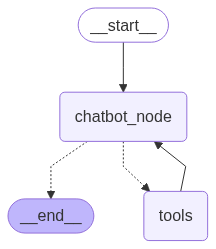

In [16]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login

from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt
from langchain_core.tools import tool

from langgraph.checkpoint.memory import MemorySaver

from IPython.display import Image, display
import json

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Tools
wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
tool_search = TavilySearchResults(api_wrapper=wrapper, max_results=2)

@tool
def human_assistance(query: str) -> str:
    """
    Request assistance from a human expert. Use this tool ONLY ONCE per conversation.
    After receiving the expert's response, you should provide an elaborated response to the user based on the information received
    based on the information received, without calling this tool again.

    Args:
        query: The query to ask the human expert.

    Returns:
        The response from the human expert.
    """
    human_response = interrupt({"query": query})
    return human_response["data"]

tools_list = [tool_search, human_assistance]

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)
# Create the LLM with tools
llm_with_tools = llm.bind_tools(tools_list)

# Tool node
tool_node = ToolNode(tools=tools_list)

# Functions
def chatbot_function(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("chatbot_node", chatbot_function)
graph_builder.add_node("tools", tool_node)

# Add edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_conditional_edges( "chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")

# Compile the graph
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Volvemos a pedirle ayuda al chatbot para crear agentes. Le pedimos que busque ayuda

In [ ]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (0)
 Call ID: 0
  Args:
    query: I need expert guidance for building an AI agent.


Vemos en qué estado se ha quedado el grafo

In [ ]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

Le damos la asistencia que está pidiendo

In [ ]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    "It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (0)
 Call ID: 0
  Args:
    query: I need expert guidance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent.It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================
Tool Calls:
  human_assistance (0)
 Call ID: 0
  Args:
    query: I need some expert guidance for building an AI agent. Could you recommend a platform and any tips for getting started?


Y por último le pedimos que busque en internet las últimas noticias de LangGraph

In [ ]:
user_input = "What's the latest news about LangGraph?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

What's the latest news about LangGraph?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (0)
 Call ID: 0
  Args:
    query: latest news about LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangChain Blog", "url": "https://blog.langchain.dev/", "content": "LangSmith Incident on May 1, 2025\n\nRequests to the US LangSmith API from both the web application and SDKs experienced an elevated error rate for 28 minutes on May 1, 2025\n\nFeatured\n\nHow Klarna's AI assistant redefined customer support at scale for 85 million active users\n\nIs LangGraph Used In Production?\n\nIntroducing Interrupt: The AI Agent Conference by LangChain\n\nTop 5 LangGraph Agents in Production 2024 [...] See how Harmonic uses LangSmith and LangGraph products to streamline v

## Personalización del estado

 > Nota: Este apartado lo vamos a hacer usando Sonnet 3.7, ya que a día de la escritura del post, es el mejor modelo para uso con agentes, y es el único que entiende cuando tiene que llamar a las tools y cuando no

Hasta ahora, hemos confiado en un estado simple con una entrada, una lista de mensajes. Se puede llegar lejos con este estado simple, pero si se desea definir un comportamiento complejo sin depender de la lista de mensajes, se pueden agregar campos adicionales al estado.

Aquí vamos a ver un nuevo escenario, en el que el chatbot está utilizando la herramienta de búsqueda para encontrar información específica, y reenviándola a un ser humano para su revisión. Vamos a hacer que el chatbot investigue el cumpleaños de una entidad. Agregaremos `name` y `birthday` como claves del estado.

Primero cargamos los valores de las API KEYs

In [5]:
import os
import dotenv

dotenv.load_dotenv()

TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

Creamos el nuevo estado

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

Agregar esta información al estado hace que sea fácilmente accesible por otros nodos del grafo (por ejemplo, un nodo que almacena o procesa la información), así como la capa de persistencia del grafo.

Ahora creamos el grafo

In [3]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

Definimos la `tool` de búsqueda

In [6]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
search_tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)

<ipython-input-6-2955814646>:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)


Ahora creamos la tool de asistencia humana. En esta tool rellenaremos las claves de estado dentro de nuestra herramienta `human_assistance`. Esto permite a un ser humano revisar la información antes de que se almacene en el estado. Volveremos a usar `Command`, esta vez para emitir una actualización de estado desde el interior de nuestra herramienta.

In [7]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt


@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """
    Request assistance from a human expert. Use this tool ONLY ONCE per conversation.
    After receiving the expert's response, you should provide an elaborated response to the user based on the information received
    based on the information received, without calling this tool again.

    Args:
        query: The query to ask the human expert.

    Returns:
        The response from the human expert.
    """
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )

    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"

    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }

    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

Hemos usado [ToolMessage](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.tool.ToolMessage.html) que se usa para pasar el resultado de ejecutar una `tool` de nuevo a un modelo y [InjectedToolCallId](https://python.langchain.com/api_reference/core/tools/langchain_core.tools.base.InjectedToolCallId.html)

Creamos una lista de `tools`

In [8]:
tools_list = [search_tool, human_assistance]

A continuación, el `LLM` con las `bind_tools` y lo añadimos al grafo

In [9]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_anthropic import ChatAnthropic


# Create the LLM
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", api_key=ANTHROPIC_TOKEN)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools_list)

# Define the chatbot function
def chatbot_function(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

# Add the chatbot node
graph_builder.add_node("chatbot_node", chatbot_function)

Añadimos la `tool` al grafo

In [10]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools=tools_list)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")

Añadimos el nodo de `START` al grafo

In [11]:
graph_builder.add_edge(START, "chatbot_node")

Creamos un `checkpointer` [MemorySaver](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver).

In [12]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

Compilamos el grafo con el `checkpointer`

In [13]:
graph = graph_builder.compile(checkpointer=memory)

Lo representamos gráficamente

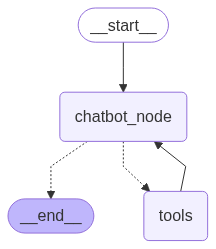

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Vamos a pedir a nuestro chatbot que busque el "cumpleaños" de la biblioteca de `LangGraph`.

Dirigiremos al chatbot hasta la herramienta `human_assistance` una vez que tenga la información requerida. Los argumentos `name` y `birthday` son obligatorios para la herramienta `human_assistance`, así que obligan al chatbot a generar propuestas para estos campos.

In [15]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================

[{'text': "I'll search for information about LangGraph's release date and then get it verified through human assistance.", 'type': 'text'}, {'id': 'toolu_016hRSLkbrBXz1iTdTaMPoTZ', 'input': {'query': 'When was LangGraph released launch date'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_016hRSLkbrBXz1iTdTaMPoTZ)
 Call ID: toolu_016hRSLkbrBXz1iTdTaMPoTZ
  Args:
    query: When was LangGraph released launch date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangChain Introduces LangGraph Studio: The First Agent IDE for ...", "url": "https://www.marktechpost.com/2024/08/03/la

Se ha parado por el `interrupt` en la herramienta `human_assistance`. En este caso, el chatbot, con la herramienta de búsqueda, ha determinado que la fecha de LangGraph es enero de 2023, pero no es la fecha exacta, es el 17 de enero de 2024, por lo que podemos introducirla nosotros mismos.

In [16]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': 'Based on the search results, I found that LangGraph was launched in January 2023. Let me verify this information through human assistance.', 'type': 'text'}, {'id': 'toolu_019uAggBfC8461t8Ep2omiND', 'input': {'name': 'LangGraph', 'birthday': 'January 2023'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_019uAggBfC8461t8Ep2omiND)
 Call ID: toolu_019uAggBfC8461t8Ep2omiND
  Args:
    name: LangGraph
    birthday: January 2023
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================

Thank you for the correction from human assistance! I need to update my response:

LangGraph was actually released on January 17, 2024, not in 2023 as initially found in the search re

In [17]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

Ahora la fecha es la correcta gracias a la intervención humana para modificar los valores del estado

Vuelvo a escribir todo el código para que sea más fácil de entender

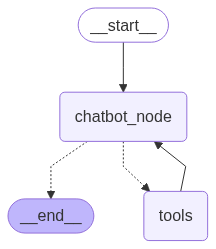

In [18]:
import os
import dotenv

from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langchain_anthropic import ChatAnthropic

dotenv.load_dotenv()
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

# Tools
wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
search_tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)

@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """
    Request assistance from a human expert. Use this tool ONLY ONCE per conversation.
    After receiving the expert's response, you should provide an elaborated response to the user based on the information received
    based on the information received, without calling this tool again.

    Args:
        query: The query to ask the human expert.

    Returns:
        The response from the human expert.
    """
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )

    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"

    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }

    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

tools_list = [search_tool, human_assistance]
tool_node = ToolNode(tools=tools_list)

# Create the LLM
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)
llm_with_tools = llm.bind_tools(tools_list)

# Define the chatbot function
def chatbot_function(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

# Graph
graph_builder = StateGraph(State)

# Nodes
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("chatbot_node", chatbot_function)

# Edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_conditional_edges("chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")

# Checkpointer
memory = MemorySaver()

# Compile
graph = graph_builder.compile(checkpointer=memory)

# Visualize
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Vamos a pedir a nuestro chatbot que busque el "cumpleaños" de la biblioteca de `LangGraph`.

In [ ]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.


Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================

[{'text': "I'll look up when LangGraph was released and then get human verification of the information.", 'type': 'text'}, {'id': 'toolu_017SLLSEnFQZVdBpj85BKHyy', 'input': {'query': 'when was LangGraph released launch date'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_017SLLSEnFQZVdBpj85BKHyy)
 Call ID: toolu_017SLLSEnFQZVdBpj85BKHyy
  Args:
    query: when was LangGraph released launch date


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangChain Introduces LangGraph Studio: The First Agent IDE for ...", "url": "https://www.marktechpost.com/2024/08/03/langchain-introduces-langgraph-studio-the-first-agent-ide-for-visualizing-interacting-with-and-debugging-complex-agentic-applications/", "content": "LangGraph, launched in January 2023, is a highly controllable, low-level orchestration framework for building agentic applications. Since its inception, it has undergone significant improvements, leading to a stable 0.1 release in June. LangGraph features a persistence layer enabling human-in-the-loop interactions and excels at building complex applications requiring domain-specific cognitive architecture.", "score": 0.83742094}, {"title": "LangGraph Studio: The first agent IDE | by Bhavik Jikadara - Medium", "url": "https://bhavikjikadara.medium.com/langgraph-studio-the-first-agent-ide-468132628274"

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================

[{'text': "Based on my search, I found that LangGraph was launched in January 2023. It's described as a low-level orchestration framework for building agentic applications. Since its release, it has seen significant improvements, including a stable 0.1 release in June (presumably 2024).\n\nLet me now get human verification of this information:", 'type': 'text'}, {'id': 'toolu_016h3391yFhtPDhQvwjNgs7W', 'input': {'name': 'Information Verification', 'birthday': 'January 2023'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_016h3391yFhtPDhQvwjNgs7W)
 Call ID: toolu_016h3391yFhtPDhQvwjNgs7W
  Args:
    name: Information Verification
    birthday: January 2023


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


Se ha parado por el `interrupt` en la herramienta `human_assistance`. En este caso, el chatbot, con la herramienta de búsqueda, ha determinado que la fecha de LangGraph es en enero de 2023, pero no es la fecha exacta, es el 17 de enero de 2024, por lo que podemos introducirla nosotros mismos.

In [ ]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "Based on my search, I found that LangGraph was launched in January 2023. It's described as a low-level orchestration framework for building agentic applications. Since its release, it has seen significant improvements, including a stable 0.1 release in June (presumably 2024).\n\nLet me now get human verification of this information:", 'type': 'text'}, {'id': 'toolu_016h3391yFhtPDhQvwjNgs7W', 'input': {'name': 'Information Verification', 'birthday': 'January 2023'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_016h3391yFhtPDhQvwjNgs7W)
 Call ID: toolu_016h3391yFhtPDhQvwjNgs7W
  Args:
    name: Information Verification
    birthday: January 2023
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai M

In [ ]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

Ahora la fecha es la correcta gracias a la intervención humana para modificar los valores del estado

## Checkpoints

En un flujo de trabajo típico de un chatbot, el usuario interactúa con el chatbot una o más veces para realizar una tarea. En las secciones anteriores, vimos cómo agregar memoria y un `human in the loop` para poder verificar nuestro estado de gráfico y controlar las respuestas futuras.

Pero, a lo mejor un usuario quiere comenzar desde una respuesta anterior y o quiere `ramificar` para explorar un resultado separado. Esto es útil para aplicaciones de agentes, cuando un flujo falla pueden volver a un checkpoint anterior y probar otra estrategia.

`LangGraph` da esta posibilidad mediante los `checkpoints`

Primero cargamos los valores de las API KEYs

In [1]:
import os
import dotenv

dotenv.load_dotenv()

ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

Creamos el nuevo estado

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

Ahora creamos el grafo

In [3]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

Definimos la `tool` de búsqueda

In [4]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
search_tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)

<ipython-input-4-2955814646>:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)


Creamos una lista de `tools`

In [5]:
tools_list = [search_tool]

A continuación, el `LLM` con las `bind_tools` y lo añadimos al grafo

In [6]:
from langchain_anthropic import ChatAnthropic
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing


# Create the LLM
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", api_key=ANTHROPIC_TOKEN)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools_list)

# Define the chatbot function
def chatbot_function(state: State):
    message = llm_with_tools.invoke(state["messages"])
    return {"messages": [message]}

# Add the chatbot node
graph_builder.add_node("chatbot_node", chatbot_function)

Añadimos la `tool` al grafo

In [7]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools=tools_list)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")

Añadimos el nodo de `START` al grafo

In [8]:
graph_builder.add_edge(START, "chatbot_node")

Creamos un `checkpointer` [MemorySaver](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver).

In [9]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

Compilamos el grafo con el `checkpointer`

In [10]:
graph = graph_builder.compile(checkpointer=memory)

Lo representamos gráficamente

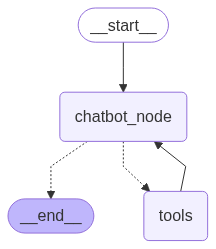

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Hagamos que nuestro grafo dé un par de pasos. Cada paso será guardado en el historial del estado.

Hacemos la primera llamada al modelo

In [12]:
config = {"configurable": {"thread_id": "1"}}

user_input = (
    "I'm learning LangGraph. "
    "Could you do some research on it for me?"
)

events = graph.stream(
    {"messages": [{"role": "user","content": user_input},],},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'text': "I'll search for information about LangGraph to help you learn about it.", 'type': 'text'}, {'id': 'toolu_019oU6pdBED1o7AdUSZD1MtF', 'input': {'query': 'LangGraph framework what is it how to use'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_019oU6pdBED1o7AdUSZD1MtF)
 Call ID: toolu_019oU6pdBED1o7AdUSZD1MtF
  Args:
    query: LangGraph framework what is it how to use
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "What Is LangGraph and How to Use It? - DataCamp", "url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "[Browse Courses](https://www.datacamp.com/courses-all)\n\ncategory\n\n1.  [H

Y ahora la segunda llamada

In [13]:
user_input = (
    "Ya that's helpful. Maybe I'll "
    "build an autonomous agent with it!"
)

events = graph.stream(
    {"messages": [{"role": "user","content": user_input},],},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

[{'text': 'Let me search for specific information about building autonomous agents with LangGraph!', 'type': 'text'}, {'id': 'toolu_018zRrXVksSdgJwuUAr1zE13', 'input': {'query': 'how to build autonomous agents with LangGraph examples tutorial'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_018zRrXVksSdgJwuUAr1zE13)
 Call ID: toolu_018zRrXVksSdgJwuUAr1zE13
  Args:
    query: how to build autonomous agents with LangGraph examples tutorial
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Build a Smart AI Agent with LangGraph & Python – 10 Min Tutorial!", "url": "https://www.youtube.com/watch?v=2_0zTWlqSP4", "content": "# Build

Ahora que hemos hecho dos llamadas al modelo, vamos a ver el historial del estado.

In [44]:
to_replay = None
for state in graph.get_state_history(config):
    if len(state.values["messages"])>0:
        print(f"Num Messages: {len(state.values['messages'][0].content)}, Next: {state.next}, checkpoint id = {state.config['configurable']['checkpoint_id']}")
    else:
        print(f"Num Messages: {len(state.values['messages'])}, Next: {state.next}, checkpoint id = {state.config['configurable']['checkpoint_id']}")
    print("-" * 80)

    # Get state when first iteracction us done
    if len(state.next) == 0:
        to_replay = state

10
Num Messages: 64, Next: (), checkpoint id = 1f0486e9-1651-6ff9-800a-6621cd19f6e8
--------------------------------------------------------------------------------
9
Num Messages: 64, Next: ('chatbot_node',), checkpoint id = 1f0486e8-bb15-6ba9-8009-784d30908fa3
--------------------------------------------------------------------------------
8
Num Messages: 64, Next: ('tools',), checkpoint id = 1f0486e8-a57f-6587-8008-8b9b972fb12d
--------------------------------------------------------------------------------
7
Num Messages: 64, Next: ('chatbot_node',), checkpoint id = 1f0486e8-96f6-6b61-8007-405305c2de54
--------------------------------------------------------------------------------
6
Num Messages: 64, Next: ('tools',), checkpoint id = 1f0486e8-7ef6-60fd-8006-6af6b23d9c25
--------------------------------------------------------------------------------
5
Num Messages: 64, Next: ('chatbot_node',), checkpoint id = 1f0486e8-643d-61c2-8005-e1ff964c89b4
-----------------------------------

Hemos guardado en `to_replay` el estado del grafo cuando nos ha dado la primera respuesta, justo antes de introducir el segundo mensaje. Podemos volver a un estado pasado y continuar el flujo desde allí.

La configuración del checkpoint contiene el `checkpoint_id`, que es un timestamp del flujo. Podemos verlo para comprobar que estamos en el estado que queremos estar.

In [45]:
print(to_replay.config)

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0486e7-f0ae-6f45-8003-feca2a64ed10'}}


Si nos fijamos en la lista de estados de antes, vemos que el ID coincide con el momento de introducir el segundo mensaje

Dando este `checkpoint_id` a `LangGraph` carga el estado en ese momento del flujo. Así que creamos un nuevo mensaje y se lo pasamos al grafo

In [46]:
user_input = (
    "Thanks"
)

# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
events = graph.stream({"messages": [{"role": "user","content": user_input},],},
    to_replay.config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Thanks
================================== Ai Message ==================================

You're welcome! If you need any specific information about LangGraph in the future, such as implementation examples, best practices, or particular use cases, feel free to ask.


In [47]:
for state in graph.get_state_history(config):
    if len(state.values["messages"])>0:
        print(f"Num Messages: {len(state.values['messages'][0].content)}, Next: {state.next}, checkpoint id = {state.config['configurable']['checkpoint_id']}")
    else:
        print(f"Num Messages: {len(state.values['messages'])}, Next: {state.next}, checkpoint id = {state.config['configurable']['checkpoint_id']}")
    print("-" * 80)

Num Messages: 64, Next: (), checkpoint id = 1f048705-02a4-6550-8006-02f37d4ae225
--------------------------------------------------------------------------------
Num Messages: 64, Next: ('chatbot_node',), checkpoint id = 1f048704-e808-6be7-8005-382c6cddfc57
--------------------------------------------------------------------------------
Num Messages: 64, Next: ('__start__',), checkpoint id = 1f048704-e801-6d18-8004-27499a80caab
--------------------------------------------------------------------------------
Num Messages: 64, Next: (), checkpoint id = 1f0486e9-1651-6ff9-800a-6621cd19f6e8
--------------------------------------------------------------------------------
Num Messages: 64, Next: ('chatbot_node',), checkpoint id = 1f0486e8-bb15-6ba9-8009-784d30908fa3
--------------------------------------------------------------------------------
Num Messages: 64, Next: ('tools',), checkpoint id = 1f0486e8-a57f-6587-8008-8b9b972fb12d
-----------------------------------------------------------

Podemos ver en el historial que el grafo ejecutó todo lo primero que hicimos, pero que luego piso el historial y volvió a ejecutar desde un punto anterior

Vuelvo a escribir todo el grafo junto

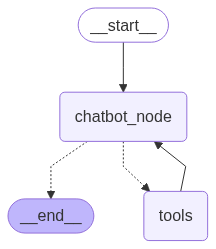

In [51]:
import os
import dotenv

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_anthropic import ChatAnthropic
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

from IPython.display import Image, display

class State(TypedDict):
    messages: Annotated[list, add_messages]

dotenv.load_dotenv()
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

# Tools
wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
search_tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)
tools_list = [search_tool]
tool_node = ToolNode(tools=tools_list)

# Create the LLM
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", api_key=ANTHROPIC_TOKEN)
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools_list)

# Define the chatbot function
def chatbot_function(state: State):
    message = llm_with_tools.invoke(state["messages"])
    return {"messages": [message]}

# Create the graph
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("chatbot_node", chatbot_function)
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge("tools", "chatbot_node")

# Add edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_conditional_edges("chatbot_node", tools_condition)

# Add checkpointer
memory = MemorySaver()

# Compile
graph = graph_builder.compile(checkpointer=memory)

# Visualize
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")


Hacemos la primera llamada al modelo

In [52]:
config = {"configurable": {"thread_id": "1"}}

user_input = (
    "I'm learning LangGraph. "
    "Could you do some research on it for me?"
)

events = graph.stream(
    {"messages": [{"role": "user","content": user_input},],},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'text': "I'll search for information about LangGraph to help you learn about it.", 'type': 'text'}, {'id': 'toolu_0199XMa7YPXmjFDijGABA2gt', 'input': {'query': 'LangGraph framework what is it how to use'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_0199XMa7YPXmjFDijGABA2gt)
 Call ID: toolu_0199XMa7YPXmjFDijGABA2gt
  Args:
    query: LangGraph framework what is it how to use
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "What Is LangGraph and How to Use It? - DataCamp", "url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "[Browse Courses](https://www.datacamp.com/courses-all)\n\ncategory\n\n1.  [H

Y ahora la segunda llamada

In [53]:
user_input = (
    "Ya that's helpful. Maybe I'll "
    "build an autonomous agent with it!"
)

events = graph.stream(
    {"messages": [{"role": "user","content": user_input},],},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

[{'text': 'Let me search for specific information about building autonomous agents with LangGraph!', 'type': 'text'}, {'id': 'toolu_01KoVXR8biyUL9oQp7gdziLA', 'input': {'query': 'how to build autonomous agents with LangGraph examples tutorial'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01KoVXR8biyUL9oQp7gdziLA)
 Call ID: toolu_01KoVXR8biyUL9oQp7gdziLA
  Args:
    query: how to build autonomous agents with LangGraph examples tutorial
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Build a Smart AI Agent with LangGraph & Python – 10 Min Tutorial!", "url": "https://www.youtube.com/watch?v=2_0zTWlqSP4", "content": "# Build

Vemos el historial del estado

In [54]:
to_replay = None
for state in graph.get_state_history(config):
    if len(state.values["messages"])>0:
        print(f"Num Messages: {len(state.values['messages'][0].content)}, Next: {state.next}, checkpoint id = {state.config['configurable']['checkpoint_id']}")
    else:
        print(f"Num Messages: {len(state.values['messages'])}, Next: {state.next}, checkpoint id = {state.config['configurable']['checkpoint_id']}")
    print("-" * 80)

    # Get state when first iteracction us done
    if len(state.next) == 0:
        to_replay = state

Num Messages: 64, Next: (), checkpoint id = 1f04870f-e913-67a7-800a-cc21a890bf5f
--------------------------------------------------------------------------------
Num Messages: 64, Next: ('chatbot_node',), checkpoint id = 1f04870e-c34a-6ae4-8009-1be8859599fe
--------------------------------------------------------------------------------
Num Messages: 64, Next: ('tools',), checkpoint id = 1f04870e-9fe9-6d7c-8008-113c276de2e1
--------------------------------------------------------------------------------
Num Messages: 64, Next: ('chatbot_node',), checkpoint id = 1f04870e-5eb7-6943-8007-f25869d23c84
--------------------------------------------------------------------------------
Num Messages: 64, Next: ('tools',), checkpoint id = 1f04870e-4e78-6f4c-8006-b3efc0972793
--------------------------------------------------------------------------------
Num Messages: 64, Next: ('chatbot_node',), checkpoint id = 1f04870e-12bb-6aa4-8005-a0b700ce5ba1
------------------------------------------------

In [55]:
print(to_replay.config)

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04870d-f02f-6296-8003-ae5417cfd159'}}


Dando este `checkpoint_id` a `LangGraph` carga el estado en ese momento del flujo. Así que creamos un nuevo mensaje y se lo pasamos al grafo

In [56]:
user_input = (
    "Thanks"
)

# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
events = graph.stream({"messages": [{"role": "user","content": user_input},],},
    to_replay.config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Thanks
================================== Ai Message ==================================

You're welcome! If you need any specific information about LangGraph or help with implementation details in the future, feel free to ask.


In [57]:
for state in graph.get_state_history(config):
    if len(state.values["messages"])>0:
        print(f"Num Messages: {len(state.values['messages'][0].content)}, Next: {state.next}, checkpoint id = {state.config['configurable']['checkpoint_id']}")
    else:
        print(f"Num Messages: {len(state.values['messages'])}, Next: {state.next}, checkpoint id = {state.config['configurable']['checkpoint_id']}")
    print("-" * 80)

Num Messages: 64, Next: (), checkpoint id = 1f048710-d0ba-6c37-8006-feae9f9f4462
--------------------------------------------------------------------------------
Num Messages: 64, Next: ('chatbot_node',), checkpoint id = 1f048710-9824-6f79-8005-5a43c59df33c
--------------------------------------------------------------------------------
Num Messages: 64, Next: ('__start__',), checkpoint id = 1f048710-9822-6a20-8004-9024936422f5
--------------------------------------------------------------------------------
Num Messages: 64, Next: (), checkpoint id = 1f04870f-e913-67a7-800a-cc21a890bf5f
--------------------------------------------------------------------------------
Num Messages: 64, Next: ('chatbot_node',), checkpoint id = 1f04870e-c34a-6ae4-8009-1be8859599fe
--------------------------------------------------------------------------------
Num Messages: 64, Next: ('tools',), checkpoint id = 1f04870e-9fe9-6d7c-8008-113c276de2e1
-----------------------------------------------------------